# <center>Predictive modelling with timeseries</center>
# <center> Part 3 - Time series forecasting with ARIMA models</center>

![Image](images/timeseries.jpg)

# Time series forecasting with ARIMA models

Very robust family of parametric models that can handle time series data with many combinations of properties.
ARIMA models have three components, the `AR` autoregressive, the `I` integrated, and `MA` moving average. the notation is put together as `ARIMA(p, d, q)`.


![Image](images/arima.png) 

In [83]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# jupyter lab configs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
plotly.offline.init_notebook_mode(connected=True)

from utils import adf_test
from utils import print_errors

In [1]:
from statsmodels.tsa.arima_model import ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima import auto_arima # on order to determine ARIMA orders
from statsmodels.tsa.stattools import adfuller

/Users/aline.ferreira-de-qu/.pyenv/versions/3.6.5/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# ETL

### Load the datasets  (Production of electrical equipments)

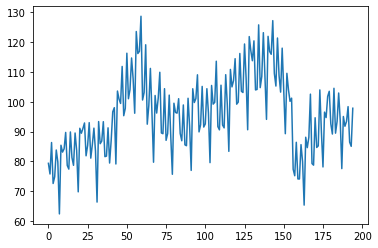

In [85]:
# load a nice example for decomposition - production of electrical equipments
ele_df = pd.read_csv('datasets/elecequip.csv')
ele_df['value'].plot()

---

### Split train and test

In [98]:
train = ele_df.loc[:150, 'value']
test = ele_df.loc[150:, 'value']
test_start = 150
test_end = 194

## Create baseline and check model performance

---

# Auto-regressive family of models

### Is the series  `stationary`?

In [87]:
adf_test(train)

Augmented Dickey-Fuller Test: 
Test the null hypothesis that the data is non-stationary
ADF test statistic       -2.790421
p-value                   0.059655
lags                     14.000000
# observations          136.000000
critical value (1%)      -3.479372
critical value (5%)      -2.883037
critical value (10%)     -2.578234
Fail to reject the null hypothesis, data is  non-stationary


0.059655072628830436

# ARMA - For a stationary series

What happens if we model this as a stationary series?
For ARMA and stationary data, we don't need the Integration/differencing parameter `d`, which is then set to 0.  We are then left with a ARMA model and heve to find the best `p` and `q`.
Let's see the impact of changing `p` and  `q`.

In [121]:
arma_model = ARIMA(train, order=(1,1,1))
results1_1 = arma_model.fit()
results1_1.summary().tables[0]

arma_model = ARIMA(train, order=(2,0,2))
results2_2 = arma_model.fit()
results2_2.summary().tables[0]

arma_model = ARIMA(train, order=(1,0,2))
results1_2 = arma_model.fit()
results1_2.summary().tables[0]

arma_model = ARIMA(train, order=(5,1,1))
results2_1 = arma_model.fit()
results2_1.summary().tables[0]

arma_model2 = ARIMA(train, order=(1,1,1))
results2_1 = arma_model2.fit()
results2_1.summary().tables[0]

Dep. Variable:,D.value,No. Observations:,150
Model:,"ARIMA(1, 1, 1)",Log Likelihood,-551.300
Method:,css-mle,S.D. of innovations,9.512
Date:,"Sat, 17 Oct 2020",AIC,1110.601
Time:,16:02:50,BIC,1122.643
Sample:,1,HQIC,1115.493
,,,


Dep. Variable:,value,No. Observations:,151
Model:,"ARMA(2, 2)",Log Likelihood,-553.602
Method:,css-mle,S.D. of innovations,9.412
Date:,"Sat, 17 Oct 2020",AIC,1119.204
Time:,16:02:50,BIC,1137.308
Sample:,0,HQIC,1126.559
,,,


Dep. Variable:,value,No. Observations:,151
Model:,"ARMA(1, 2)",Log Likelihood,-553.143
Method:,css-mle,S.D. of innovations,9.378
Date:,"Sat, 17 Oct 2020",AIC,1116.285
Time:,16:02:50,BIC,1131.372
Sample:,0,HQIC,1122.414
,,,


Dep. Variable:,D.value,No. Observations:,150
Model:,"ARIMA(5, 1, 1)",Log Likelihood,-510.409
Method:,css-mle,S.D. of innovations,7.203
Date:,"Sat, 17 Oct 2020",AIC,1036.817
Time:,16:02:51,BIC,1060.902
Sample:,1,HQIC,1046.602
,,,


Dep. Variable:,D.value,No. Observations:,150
Model:,"ARIMA(1, 1, 1)",Log Likelihood,-551.300
Method:,css-mle,S.D. of innovations,9.512
Date:,"Sat, 17 Oct 2020",AIC,1110.601
Time:,16:02:51,BIC,1122.643
Sample:,1,HQIC,1115.493
,,,


Let's predict for the test interval:

In [122]:
predictions1 = results1_1.predict(start=test_start, end=test_end).rename('ARMA(1,1) Predictions')
predictions2 = results2_2.predict(start=test_start, end=test_end).rename('ARMA(2,2) Predictions')
predictions3 = results1_2.predict(start=test_start, end=test_end).rename('ARMA(1,2) Predictions')
predictions4 = results2_1.predict(start=test_start, end=test_end).rename('ARMA(5,1) Predictions')

[Text(0, 0.5, 'Demand'), Text(0.5, 0, '')]

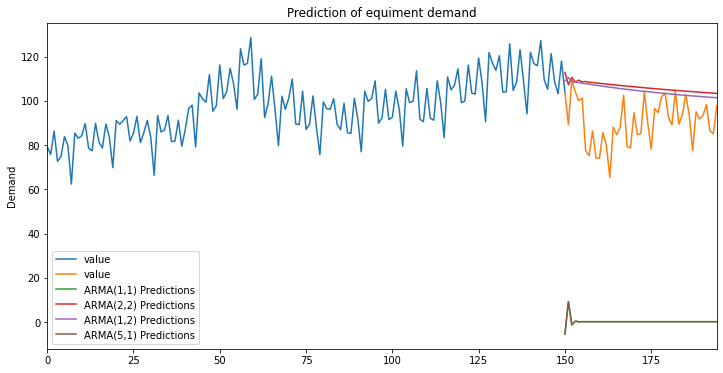

In [123]:
ylabel='Demand'
ax = train.plot(legend=True,figsize=(12,6),title='Prediction of equiment demand')
test.plot(legend=True)
predictions1.plot(legend=True)
predictions2.plot(legend=True)
predictions3.plot(legend=True)
predictions4.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel="", ylabel=ylabel)

Did you notice the change in shape of predictions when we increase the AR component to 5?

# Wait a minute!  
## Do we have to try out and plot all possible combinations of (p, d, q)?
![Image](images/boring.jpg) 

## Luckly not.   

### Using AIC and a stewise routine `auto_arima()` made available in library `pmdarima`, we can find the best (p, d, q) for the data

# Stepwise ARIMA or SARIMA

The function `auto_arima()` will fit different combinations of the orders of (p, d, q) and select the best based on the **lowest AIC**. You can indicate a seasonal model (SARIMA) if you set `seasonal=True` and change `m` to integer>1.

In [128]:
best_model = auto_arima(train, suppress_warnings=True, 
                        random=False, start_p=0, start_q=0, 
                        stepwise=False,
                        random_state=42)
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  151
Model:               SARIMAX(2, 1, 3)   Log Likelihood                -494.173
Date:                Sat, 17 Oct 2020   AIC                           1002.347
Time:                        16:15:49   BIC                           1023.421
Sample:                             0   HQIC                          1010.909
                                - 151                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4886      0.730      0.669      0.504      -0.943       1.920
ar.L1         -1.0000      0.006   -160.348      0.000      -1.012      -0.988
ar.L2         -0.9985      0.004   -239.313      0.000      -1.007      -0.990
ma.L1          0.3970      0.082      4.817      0.000       0.235       0.559
ma.L2          0.3152      0.111      2.845      0.004       0.098       0.532
ma.L3         -0.6256      0.094     -6.638      0.000      -0.810      -0.441
sigma2        44.4456      6.515      6.822      0.000      31.677      57.214
===================================================================================
Ljung-Box (Q):                      322.32   Jarque-Bera (JB):                 2.32
Prob(Q):                              0.00   Prob(JB):                         0.31
Heteroskedasticity (H):               0.96   Skew:                            -0.30
Prob(H) (two-sided):                  0.88   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### What does it mean? 

The `auto_arima` is telling us that the best model (= lowest AIC) to treat these data is a 
> ARIMA(5, 1, 2) 

*p.s. An SARIMAX or SARIMA without a (P,D,Q)m component is the equivalent of an ARIMA*

### Now, what is the performance on actual test data?

In [130]:
best_model = ARIMA(train, order=(2,1,3))
results = best_model.fit()

# predict
predictions = results.predict(start=test_start, end=test_end, 
                              dynamic=False, typ='levels').rename('SARIMAX(5,1,2) Predictions')

/Users/aline.ferreira-de-qu/.pyenv/versions/3.6.5/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning:

overflow encountered in exp

/Users/aline.ferreira-de-qu/.pyenv/versions/3.6.5/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:689: RuntimeWarning:

invalid value encountered in true_divide

/Users/aline.ferreira-de-qu/.pyenv/versions/3.6.5/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning:

overflow encountered in exp

/Users/aline.ferreira-de-qu/.pyenv/versions/3.6.5/lib/python3.6/site-packages/statsmodels/tsa/tsatools.py:690: RuntimeWarning:

invalid value encountered in true_divide

/Users/aline.ferreira-de-qu/.pyenv/versions/3.6.5/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/Users/aline.ferreira-de-qu/.pyenv/versions/3.6.5/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood opti

## How is the forecasting looking like in the `test` data?

[Text(0, 0.5, 'Demand'), Text(0.5, 0, '')]

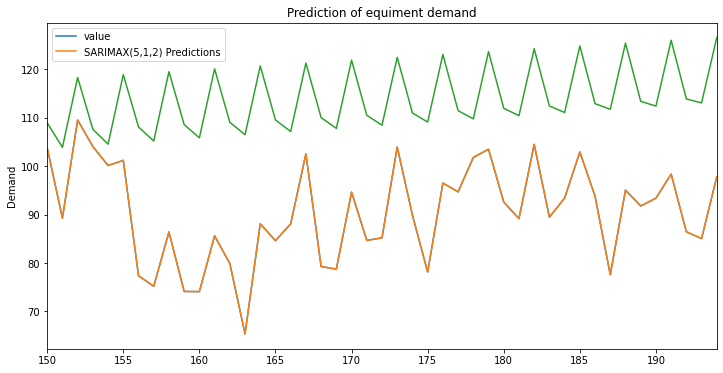

In [131]:
ylabel='Demand'
ax = test.plot(legend=True,figsize=(12,6),title='Prediction of equiment demand')
test.plot()
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel="", ylabel=ylabel)

/Users/aline.ferreira-de-qu/.pyenv/versions/3.6.5/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




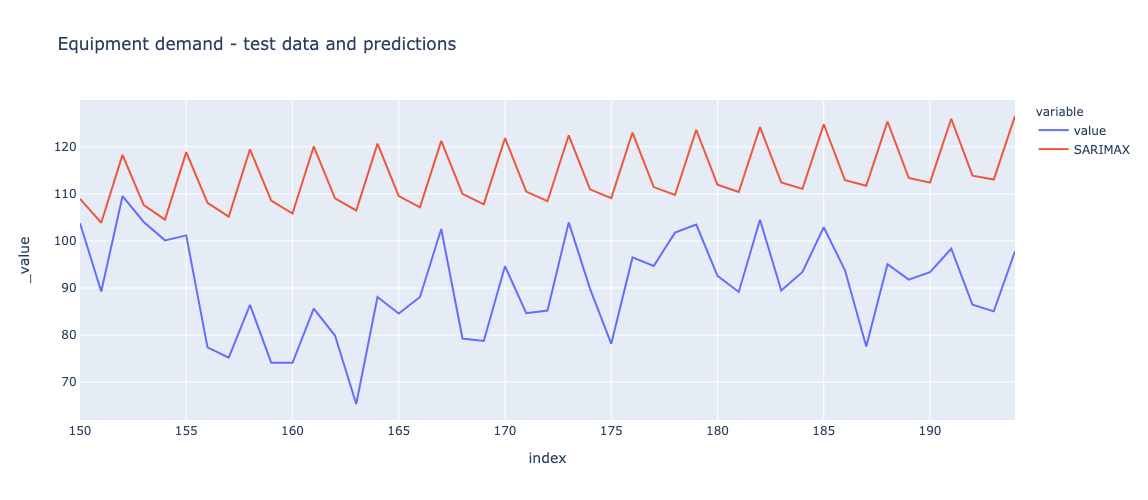

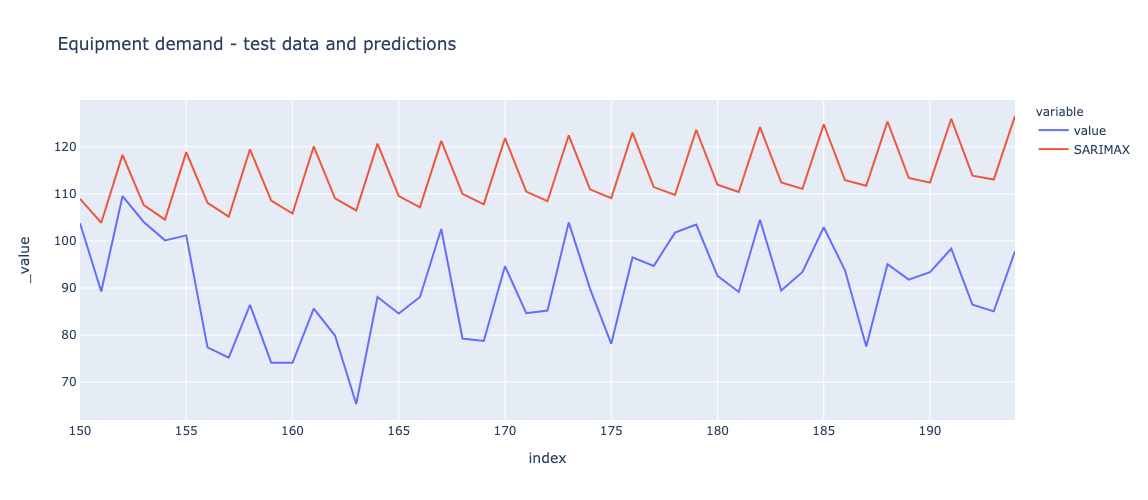

In [132]:
fig = px.line(test, title="Equipment demand - test data and predictions",  width=900, height=500)
fig.add_trace(go.Line(x=test.index, y=predictions,
                    mode='lines', name='SARIMAX'))
fig.show()

## Model evaluation:

In [133]:
print_errors(test, predictions, 'Test set')

ERRORS in Test set
MAE: 23.347678087305585
RMSE: 24.84142252973324
MAPE: 26.68141398141773
RMSPE: 0.29255848620041136


----

### Can we improve our predictions?
# Adding the seasonal component (SARIMA)

In [95]:
best_model = auto_arima(train, suppress_warnings=True, start_p=0, start_q=0, m=6)
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  151
Model:             SARIMAX(3, 1, 0)x(2, 0, [1], 6)   Log Likelihood                -419.957
Date:                             Sat, 17 Oct 2020   AIC                            853.914
Time:                                     14:55:28   BIC                            874.988
Sample:                                          0   HQIC                           862.476
                                             - 151                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3767      0.088     -4.281      0.000      -0.549      -0.204
ar.L2         -0.1994      0.091     -2.203      0.028      -0.377      -0.022
ar.L3          0.1473      0.080      1.831      0.067      -0.010       0.305
ar.S.L6        0.0007      0.035      0.019      0.985      -0.069       0.070
ar.S.L12       0.9110      0.031     29.121      0.000       0.850       0.972
ma.S.L6        0.2883      0.098      2.938      0.003       0.096       0.481
sigma2        13.7316      1.754      7.827      0.000      10.293      17.170
===================================================================================
Ljung-Box (Q):                       48.97   Jarque-Bera (JB):                 1.98
Prob(Q):                              0.16   Prob(JB):                         0.37
Heteroskedasticity (H):               0.78   Skew:                            -0.26
Prob(H) (two-sided):                  0.39   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [112]:
best_model = SARIMAX(train, order=(3,1,0), seasonal_order=(2,0,1,6))
results = best_model.fit()

# predict
predictions = results.predict(start=test_start, end=test_end, 
                              dynamic=False, typ='levels').rename('SARIMAX Predictions')
print_errors(test, predictions, 'Test set')

ERRORS in Test set
MAE: 10.668492506253832
RMSE: 12.366727676180545
MAPE: 12.201464213238465
RMSPE: 0.14630178598381963


/Users/aline.ferreira-de-qu/.pyenv/versions/3.6.5/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




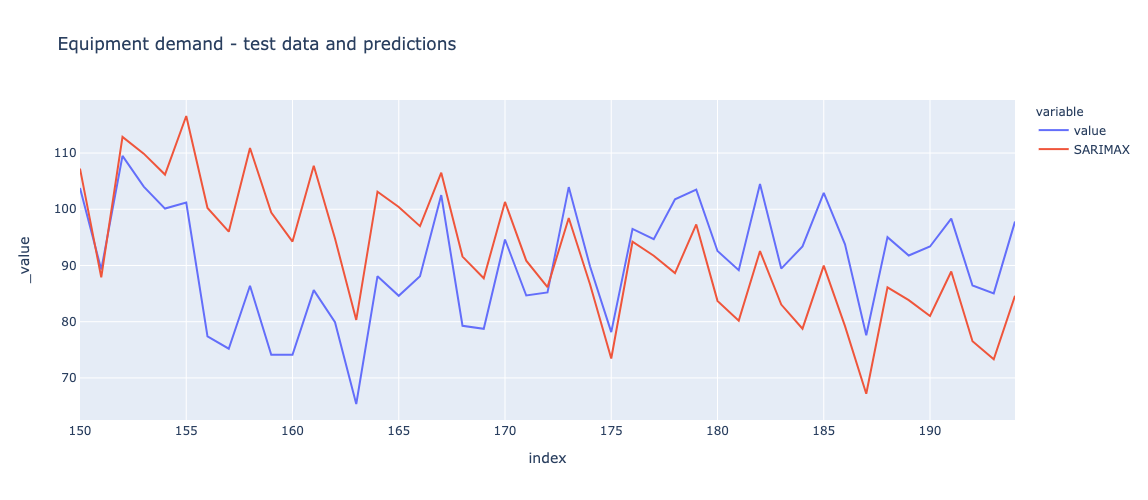

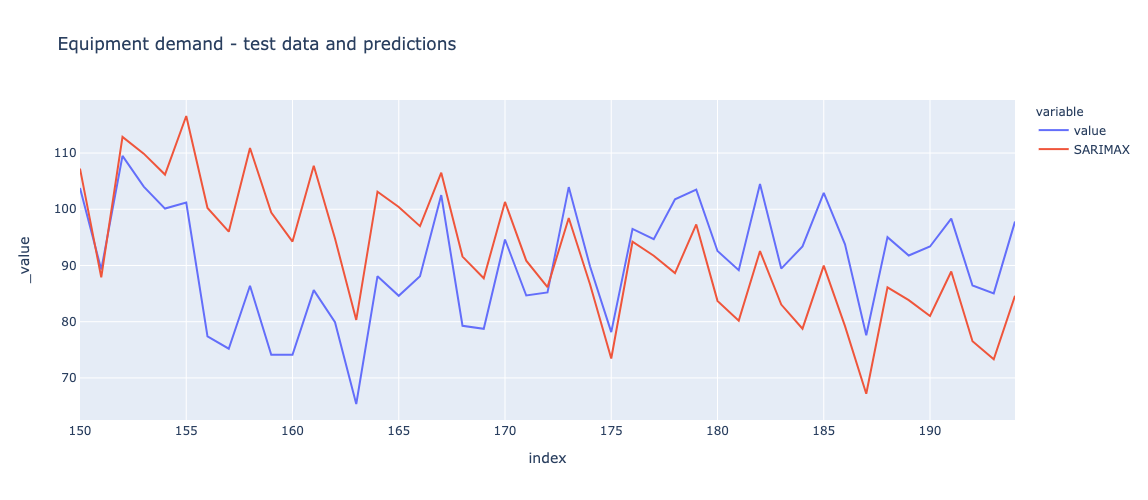

In [113]:
fig = px.line(test, title="Equipment demand - test data and predictions",  width=900, height=500)
fig.add_trace(go.Line(x=test.index, y=predictions,
                    mode='lines', name='SARIMAX'))
fig.show()

---

---

<a href='https://www.freepik.com/vectors/business'>Business vector created by freepik - www.freepik.com</a>